# Virus-Host Species Relation Extraction
## Notebook 4
### UC Davis Epicenter for Disease Dynamics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import numpy as np
from snorkel import SnorkelSession
import pandas as pd
session = SnorkelSession()
# Connect to the database backend and initalize a Snorkel session

#from lib.init import *
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

VirusHost = candidate_subclass('VirusHost', ['virus', 'host'])

In [2]:
from snorkel.annotations import load_marginals

train_cands = session.query(VirusHost).filter(VirusHost.split == 0).order_by(VirusHost.id).all()
dev_cands   = session.query(VirusHost).filter(VirusHost.split == 1).order_by(VirusHost.id).all()
test_cands  = session.query(VirusHost).filter(VirusHost.split == 2).order_by(VirusHost.id).all()

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True)

train_marginals = load_marginals(session, split=0)

In [3]:
from util_virushost import load_external_labels

missed = load_external_labels(session, VirusHost, annotator_name = 'gold', split = 2)

L_gold_test = load_gold_labels(session, annotator_name = 'gold', split = 2)
L_gold_test

AnnotatorLabels created: 0


<357x1 sparse matrix of type '<class 'numpy.int32'>'
	with 38 stored elements in Compressed Sparse Row format>

## Training a Long Short-Term Memory (LSTM) Neural Network

We will train a bi-directional LSTM deep learning model for our end extraction by using the probabilistic training labels generated from Notebook 3. The model is implemented in Tensorflow, an open source machine learning library. Training an end model, instead of simply using the generative model, allows us to generalize to new data, beyond the heuristics of the labeling functions. 

##### Additional Information from Snorkel:

In deep learning, hyperparameter tuning is very important and computationally expensive step in training models. In our project, the optimal hyperparameters were selected by a random grid search.


| Parameter           | Definition                                            |
|---------------------|--------------------------------------------------------------------------------------------------------|
| n_epochs            | A single pass through all the data in your training set                                                |
| dim                 | Vector embedding (i.e., learned representation) dimension                                              |
| lr,                 | The learning rate by which we update model weights after,computing the gradient                        |
| dropout             | A neural network regularization techique [0.0 - 1.0]                                                   |
| print_freq          | Print updates every k epochs                                                                           |
| batch_size          | Estimate the gradient using k samples. Larger batch sizes run faster, but may perform worse            |
| max_sentence_length | The max length of an input sequence. Setting this too large, can slow your training down substantially 

In [4]:
from snorkel.learning.utils import GridSearch
from snorkel.learning.pytorch.rnn import LSTM

# search over this parameter grid 
param_grid = {
    'lr': [1e-3, 1e-2],    # learning rate
    'dropout': [0.2, 0.5],       # dropout rate
#    'batch_size': [128, 256],     # batch size
#    'n_epochs': [10, 20]     # number of epochs
}

model_hyperparams = {
    'embedding_dim':   100,
    'hidden_dim':      100,
    'rebalance':       0.25,
    'print_freq':      5,
    'n_epochs': 10,
    'batch_size': 128,
    'dropout': 0.2
}

#model_class_params = {
#    'n_threads':1
#}

grid_search = GridSearch(model_class = LSTM, parameter_dict = param_grid, 
                         X_train = train_cands, Y_train = train_marginals, 
                         model_hyperparams = model_hyperparams)

print("Discriminitive Model Parameter Space (seed=123):")
for i, params in enumerate(grid_search.search_space()):
    print("Model {}: Trying parameters {}".format(i, params))

disc_model, run_stats = grid_search.fit(X_valid = dev_cands, Y_valid = L_gold_dev)

Discriminitive Model Parameter Space (seed=123):
Model 0: Trying parameters (0.001, 0.2)
Model 1: Trying parameters (0.001, 0.5)
Model 2: Trying parameters (0.01, 0.2)
Model 3: Trying parameters (0.01, 0.5)
[1] Testing lr = 1.00e-03, dropout = 2.00e-01
[LSTM] Training model
[LSTM] n_train=3108  #epochs=10  batch size=128


C:\Users\ericaxia3\Anaconda3\envs\snorkel\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Epoch 1 (252.97s)	Average loss=0.609740	Dev F1=70.48
[LSTM] Epoch 6 (1363.15s)	Average loss=0.430431	Dev F1=63.59
[LSTM] Epoch 10 (2184.27s)	Average loss=0.408065	Dev F1=73.42
[LSTM] Model saved as <LSTM>
[LSTM] Training done (2184.56s)
[LSTM] Loaded model <LSTM>
[LSTM] F-1 Score: 0.7341772151898734
[LSTM] Model saved as <LSTM_0>
[LSTM] Model saved as <LSTM_best>
[2] Testing lr = 1.00e-03, dropout = 5.00e-01
[LSTM] Training model
[LSTM] n_train=3108  #epochs=10  batch size=128
[LSTM] Epoch 1 (220.22s)	Average loss=0.615698	Dev F1=68.75
[LSTM] Epoch 6 (1301.36s)	Average loss=0.435543	Dev F1=67.86
[LSTM] Epoch 10 (2120.36s)	Average loss=0.410882	Dev F1=73.95
[LSTM] Model saved as <LSTM>
[LSTM] Training done (2120.63s)
[LSTM] Loaded model <LSTM>
[LSTM] F-1 Score: 0.7394957983193275
[LSTM] Model saved as <LSTM_1>
[LSTM] Model saved as <LSTM_best>
[3] Testing lr = 1.00e-02, dropout = 2.00e-01
[LSTM] Training model
[LSTM] n_train=3108  #epochs=10  batch size=128
[LSTM] Epoch 1 (223.00

In [5]:
run_stats

,lr,dropout,Prec.,Rec.,F-1
1,0.001,0.5,0.698413,0.785714,0.739496
3,0.010,0.5,0.701613,0.776786,0.737288
0,0.001,0.2,0.696000,0.776786,0.734177
2,0.010,0.2,0.698276,0.723214,0.710526


## Model Metrics

In [6]:
# scores for the best selected model
p, r, f1 = disc_model.score(test_cands, L_gold_test, set_unlabeled_as_neg=False)  
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.973, Recall: 0.973, F1 Score: 0.973


In [7]:
tp, fp, tn, fn = disc_model.error_analysis(session, test_cands, L_gold_test, set_unlabeled_as_neg=False) 

Scores (Un-adjusted)
Pos. class accuracy: 0.973
Neg. class accuracy: 0.0
Precision            0.973
Recall               0.973
F1                   0.973
----------------------------------------
TP: 36 | FP: 1 | TN: 0 | FN: 1



In [8]:
# view examples
from snorkel.viewer import SentenceNgramViewer

SentenceNgramViewer(fp, session, height = 350)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[0]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,…

In [9]:
# save model for later use
disc_model.save("virushost.lstm")

[LSTM] Model saved as <virushost.lstm>


In [10]:
# save the predictions of the model on the test set back to the database
disc_model.save_marginals(session, test_cands, training=False)

C:\Users\ericaxia3\Anaconda3\envs\snorkel\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Saved 357 marginals


In [11]:
test_marginals = load_marginals(session, X=test_cands, split=2, training=False)

In [12]:
len(test_marginals)

357

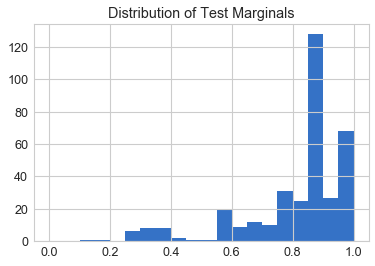

In [13]:
# plot the test marginals
import matplotlib.pyplot as plt
plt.hist(test_marginals, bins=20, range=(0.0, 1.0))
plt.title('Distribution of Test Marginals')
plt.show()

In [14]:
# export all candidates to csv file
df = pd.DataFrame({'id': [], 'virus': [], 'host': []})

# list all candidates (to export later and merge w predicted probabilities table?)
for c in session.query(VirusHost).all():
    df = df.append({'id': c.id, 'virus': c.virus.get_attrib_tokens("words"), 'host': c.host.get_attrib_tokens("words")}, ignore_index=True)
    
df2 = df[:]
df2['virus'] = df['virus'].str.join(' ')
df2['host'] = df['host'].str.join(' ')
df2['virus'] = df2['virus'].str.replace('[^a-zA-Z ]', '')
df2['host'] = df2['host'].str.replace('[^a-zA-Z ]', '')
df2['id'] = df['id'].astype('int64')
df2.to_csv('candidates.csv', index = False)

In [15]:
# exported marginals table using sqlite to a csv file, deleted unneeded columns, edited column names to 'id' and 'probability_positive' using Excel